In [15]:
from IPython.core.pylabtools import figsize
import numpy as np
from numpy.random import dirichlet
from matplotlib import pyplot as plt
from scipy.stats import beta, ttest_rel
%matplotlib inline
figsize(12.5, 4)

データ作成

In [2]:
n = 250
mu_a, std_a = 30, 4
mu_b, std_b = 26, 7

durations_a = np.random.normal(mu_a, std_a, size=n)
durations_b = np.random.normal(mu_b, std_b, size=n)

In [3]:
print(durations_a[:8])
print(durations_b[:8])

[ 31.36818684  23.81112781  35.7224307   26.82656201  33.93419251
  31.83574893  28.00167145  26.76281222]
[ 10.86991901  14.85919005  26.94126976  20.70317792  22.97948978
  14.73700854  32.71649182  22.66712684]


平均値の事前分布の定義

In [4]:
import pymc as pm
pooled_mean = np.r_[durations_a, durations_b].mean()
pooled_std = np.r_[durations_a, durations_b].std()

#pymcでは標準偏差ではなく精度を使う
tau = 1.  / np.sqrt(1000. * pooled_std)

mu_a = pm.Normal("mu_a", pooled_mean, tau)
mu_b = pm.Normal("mu_b", pooled_mean, tau)

標準偏差の事前分布の定義

In [5]:
std_a = pm.Uniform("std_a", pooled_std / 1000.,
                                      1000. * pooled_std)
std_b = pm.Uniform("std_b", pooled_std / 1000.,
                                      1000. * pooled_std)

t検定のパラメータ、νの分布を定義

In [6]:
nu_minus_1 = pm.Exponential("nu-1", 1. / 29)

モデル構築

In [7]:
obs_a = pm.NoncentralT("obs_a", mu_a,
                                              1.0 / std_a**2, nu_minus_1 + 1,
                                                observed=True, value=durations_a)
obs_b = pm.NoncentralT("obs_b", mu_b,
                                              1.0 / std_b**2, nu_minus_1 + 1,
                                                observed=True, value=durations_b)

In [8]:
mcmc = pm.MCMC([obs_a, obs_b,
                                   mu_a, mu_b, std_a, std_b, nu_minus_1])
mcmc.sample(25000, 10000)

 [-----------------100%-----------------] 25000 of 25000 complete in 7.2 sec

In [9]:
mu_a_trace = mcmc.trace('mu_a')[:]
mu_b_trace = mcmc.trace('mu_b')[:]
std_a_trace = mcmc.trace('std_a')[:]
std_b_trace = mcmc.trace('std_b')[:]
nu_trace = mcmc.trace("nu-1")[:] + 1

In [10]:
figsize(12, 8)

def _hist(data, label, **kwargs):
    return plt.hist(data, bins=40, histtype='stepfilled',
                   alpha=.95, label=label, **kwargs)

/Users/daron/.pyenv/versions/anaconda3-4.3.1/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


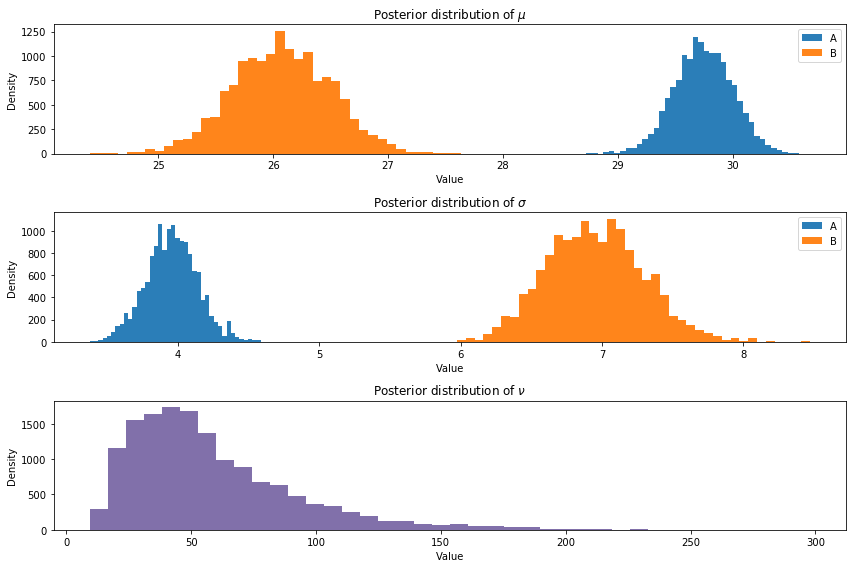

In [14]:
ax = plt.subplot(3, 1, 1)
_hist(mu_a_trace, 'A')
_hist(mu_b_trace, 'B')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior distribution of $\mu$')

ax = plt.subplot(3, 1, 2)
_hist(std_a_trace, 'A')
_hist(std_b_trace, 'B')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior distribution of $\sigma$')

ax = plt.subplot(3, 1, 3)
_hist(nu_trace, '', color='#7A68A6')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(r'Posterior distribution of $\nu$')

plt.tight_layout()

一般のt検定

In [16]:
t, p = ttest_rel(durations_a, durations_b)

In [17]:
print( "p値 = %(p)s" %locals() )

p値 = 2.31597943405e-11
